#Importing Required Libraries

In [ ]:
#python libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from google.colab import drive  
import gzip

#Sklearn libraries
from sklearn.cluster import KMeans
from sklearn.metrics import  normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

#neural networks libraries
from tensorflow import keras
import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import VarianceScaling

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/HPC Dataset

/content/drive/MyDrive/HPC Dataset


In [ ]:
!pwd

/content/drive/MyDrive/HPC Dataset


# 1. Loading Dataset

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/HPC Dataset/r206n05.gzip')

loading dataset using read_parquet method from pandas.

In [ ]:
df = df.drop(['label','timestamp'],axis=1)

Droped label and Timestamp columns from the dataset

In [ ]:
df.head()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,max:dimm10_temp,min:dimm10_temp,avg:dimm11_temp,var:dimm11_temp,max:dimm11_temp,min:dimm11_temp,avg:dimm12_temp,var:dimm12_temp,max:dimm12_temp,min:dimm12_temp,avg:dimm13_temp,var:dimm13_temp,max:dimm13_temp,min:dimm13_temp,avg:dimm14_temp,var:dimm14_temp,max:dimm14_temp,min:dimm14_temp,avg:dimm15_temp,var:dimm15_temp,max:dimm15_temp,min:dimm15_temp,avg:dimm1_temp,var:dimm1_temp,max:dimm1_temp,min:dimm1_temp,avg:dimm2_temp,var:dimm2_temp,max:dimm2_temp,min:dimm2_temp,...,var:mem_free,max:mem_free,min:mem_free,avg:mem_shared,var:mem_shared,max:mem_shared,min:mem_shared,avg:mem_total,var:mem_total,max:mem_total,min:mem_total,avg:part_max_used,var:part_max_used,max:part_max_used,min:part_max_used,avg:pkts_in,var:pkts_in,max:pkts_in,min:pkts_in,avg:pkts_out,var:pkts_out,max:pkts_out,min:pkts_out,avg:proc_run,var:proc_run,max:proc_run,min:proc_run,avg:proc_total,var:proc_total,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,New_label
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27,21.353846,0.101026,21.8,20.8,30.076923,0.076923,31,30,29.0,0.0,29,29,28.230769,0.192308,29,28,29.384615,0.256410,30,29,29.0,0.0,29,29,28.615385,0.256410,29,28,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,4.953429e+06,286699392.0,286695168.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,566.60,73.6898,572.67,560.53,41.420,200.00000,51.42,31.42,4.0,0.0,4,4,2031.666667,1.333333,2033,2031,3593600.0,0.0,3593600,3593600,4194240,0.0,4194240,4194240,0
30,21.384615,0.189744,22.0,20.8,30.230769,0.192308,31,30,29.0,0.0,29,29,28.615385,0.256410,29,28,30.000000,0.000000,30,30,29.0,0.0,29,29,29.000000,0.000000,29,29,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,4.066111e+08,286697344.0,286648000.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,586.96,0.0000,586.96,586.96,50.270,0.00000,50.27,50.27,4.0,0.0,4,4,2033.666667,9.333333,2037,2031,3593702.4,1228.8,3593728,3593664,4194240,0.0,4194240,4194240,0
33,21.169231,0.078974,21.6,20.8,30.000000,0.000000,30,30,29.0,0.0,29,29,28.230769,0.192308,29,28,29.769231,0.192308,30,29,29.0,0.0,29,29,28.538462,0.269231,29,28,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,1.374549e+06,286703296.0,286700864.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,568.65,0.0000,568.65,568.65,34.590,0.00000,34.59,34.59,4.0,0.0,4,4,2032.500000,0.333333,2033,2032,3593792.0,0.0,3593792,3593792,4194240,0.0,4194240,4194240,0
36,21.615385,0.083077,22.0,21.0,30.384615,0.256410,31,30,29.0,0.0,29,29,28.846154,0.141026,29,28,29.769231,0.192308,30,29,29.0,0.0,29,29,28.692308,0.230769,29,28,30.000000,0.000000,30,30,31.0,0.0,31,31,31.000000,0.000000,31,31,...,1.168766e+08,286701248.0,286681664.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,566.66,658.1192,584.80,548.52,48.075,703.50005,66.83,29.32,4.0,0.0,4,4,2034.666667,4.333333,2037,2033,3593920.0,0.0,3593920,3593920,4194240,0.0,4194240,4194240,0
39,21.153846,0.174359,21.8,20.6,30.000000,0.000000,30,30,29.0,0.0,29,29,28.230769,0.192308,29,28,29.923077,0.076923,30,29,29.0,0.0,29,29,28.923077,0.076923,29,28,30.076923,0.076923,31,30,31.0,0.0,31,31,30.846154,0.141026,31,30,...,2.609152e+06,286705088.0,286701888.0,0,0.0,0,0,329873088.0,0.0,329873088.0,329873088.0,27.5,0.0,27.5,27.5,571.60,0.0000,571.60,571.60,31.840,0.00000,31.84,31.84,4.0,0.0,4,4,2032.333333,14.333333,2035,2028,3593984.0,0.0,3593984,3593984,4194240,0.0,4194240,4194240,0


# 2. Data Preprocessing

## 2.1 Information of Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15310 entries, 27 to 96192
Columns: 461 entries, avg:ambient to New_label
dtypes: float64(265), int64(196)
memory usage: 54.0 MB


In [ ]:
df.shape

(15310, 461)

In [ ]:
df.describe()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,max:dimm10_temp,min:dimm10_temp,avg:dimm11_temp,var:dimm11_temp,max:dimm11_temp,min:dimm11_temp,avg:dimm12_temp,var:dimm12_temp,max:dimm12_temp,min:dimm12_temp,avg:dimm13_temp,var:dimm13_temp,max:dimm13_temp,min:dimm13_temp,avg:dimm14_temp,var:dimm14_temp,max:dimm14_temp,min:dimm14_temp,avg:dimm15_temp,var:dimm15_temp,max:dimm15_temp,min:dimm15_temp,avg:dimm1_temp,var:dimm1_temp,max:dimm1_temp,min:dimm1_temp,avg:dimm2_temp,var:dimm2_temp,max:dimm2_temp,min:dimm2_temp,...,var:mem_free,max:mem_free,min:mem_free,avg:mem_shared,var:mem_shared,max:mem_shared,min:mem_shared,avg:mem_total,var:mem_total,max:mem_total,min:mem_total,avg:part_max_used,var:part_max_used,max:part_max_used,min:part_max_used,avg:pkts_in,var:pkts_in,max:pkts_in,min:pkts_in,avg:pkts_out,var:pkts_out,max:pkts_out,min:pkts_out,avg:proc_run,var:proc_run,max:proc_run,min:proc_run,avg:proc_total,var:proc_total,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,New_label
count,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.00000,15310.000000,15310.000000,15310.000000,15310.000000,...,1.531000e+04,1.531000e+04,1.531000e+04,15310.0,15310.0,15310.0,15310.0,1.531000e+04,1.531000e+04,1.531000e+04,1.531000e+04,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,1.531000e+04,15310.000000,15310.000000,15310.000000,1.531000e+04,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,15310.000000,1.531000e+04,1.531000e+04,1.531000e+04,1.531000e+04,15310.0,15310.0,15310.0,15310.0,15310.000000
mean,18.716309,0.041324,18.940888,18.489288,27.082400,0.073318,27.264533,26.897257,27.616306,0.062888,27.770020,27.456303,26.746158,0.059816,26.899282,26.593730,28.284319,0.054541,28.422142,28.146636,28.036971,0.052043,28.171718,27.900457,27.282826,0.055404,27.425082,27.134553,29.144904,0.054030,29.277335,29.011626,27.727007,0.073613,27.907838,27.54337,27.455028,0.073310,27.631287,27.269040,...,1.702010e+14,2.722686e+08,2.620881e+08,0.0,0.0,0.0,0.0,3.298712e+08,8.551199e+10,3.298729e+08,3.298686e+08,30.804193,0.000049,30.804226,30.804128,128.873508,5.442567e+05,161.338372,108.027613,93.567569,5.659367e+05,133.210568,69.797506,18.704123,121.751347,22.564925,14.915088,2466.528028,201.218219,2471.037818,2461.721816,3.586335e+06,5.954080e+08,3.587052e+06,3.585617e+06,4194240.0,0.0,4194240.0,4194240.0,0.049510
std,2.482816,0.097875,2.505538,2.466572,2.421890,0.142473,2.452004,2.409420,2.378890,0.161412,2.419428,2.357913,2.311058,0.136461,2.343664,2.293094,2.355177,0.143016,2.394726,2.335975,2.310773,0.125796,2.335887,2.298973,2.335523,0.121861,2.366062,2.322556,2.446185,0.157551,2.482053,2.427496,2.392586,0.154271,2.435650,2.37184,2.369092,0.151518,2.403587,2.363289,...,7.508565e+14,4.666930e+07,5.896779e+07,0.0,0.0,0.0,0.0,2.135554e+05,1.058070e+13,4.534989e+02,5.338899e+05,3.002500,0.006061,3.002478,3.002561,445.783245,6.620769e+07,1290.093192,130.641526,436.820203,6.625271e+07,1323.881179,46.737991,27.852179,605.891266,32.445941,25.781654,553.608159,2000.095383,553.419675,554.162798,4.641056e+05,2.908237e+10,4.617490e+05,4.674183e+05,0.0,0.0,0.0,0.0,0.310766
min,10.426667,0.000000,10.600000,10.000000,20.266667,0.000000,21.000000,20.000000,20.000000,0.000000,20.000000,20.000000,19.000000,0.000000,19.000000,19.000000,20.666667,0.000000,21.000000,20.000000,20.400000,0.000000,21.00000

In [ ]:
df.isnull().sum()

avg:ambient       0
var:ambient       0
max:ambient       0
min:ambient       0
avg:dimm0_temp    0
                 ..
avg:swap_total    0
var:swap_total    0
max:swap_total    0
min:swap_total    0
New_label         0
Length: 461, dtype: int64

We can observe that there are no missing values in the dataset.

## 2.2 Splitting the Data into X and Y

In [ ]:
X = df.drop('New_label',axis=1)
y = df.New_label

Here we have to split the dataset into X (design matrix) and y (true labels).

In [ ]:
 y = y.apply(lambda x: 1 if x == 2 else 0)

Here we can observe that there are two values in y. 0 means normal state of the node, 2 means anomalous state. So we are going to map 2 values with 1 values for our convenience in evaluation part.

In [ ]:
y.value_counts()

0    14931
1      379
Name: New_label, dtype: int64

Here, we can see that class 0 has 14,931 entries and class 1 has only 379. There is lot of Imbalanceness in dataset. But these class 1 values are Anomalous state. 

## 2.3 Scaling Features

In [ ]:
columns = list(X.columns.values)
scaler = MinMaxScaler() 
X[columns] = scaler.fit_transform(X[columns])
X.head()

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,max:dimm10_temp,min:dimm10_temp,avg:dimm11_temp,var:dimm11_temp,max:dimm11_temp,min:dimm11_temp,avg:dimm12_temp,var:dimm12_temp,max:dimm12_temp,min:dimm12_temp,avg:dimm13_temp,var:dimm13_temp,max:dimm13_temp,min:dimm13_temp,avg:dimm14_temp,var:dimm14_temp,max:dimm14_temp,min:dimm14_temp,avg:dimm15_temp,var:dimm15_temp,max:dimm15_temp,min:dimm15_temp,avg:dimm1_temp,var:dimm1_temp,max:dimm1_temp,min:dimm1_temp,avg:dimm2_temp,var:dimm2_temp,max:dimm2_temp,min:dimm2_temp,...,avg:mem_free,var:mem_free,max:mem_free,min:mem_free,avg:mem_shared,var:mem_shared,max:mem_shared,min:mem_shared,avg:mem_total,var:mem_total,max:mem_total,min:mem_total,avg:part_max_used,var:part_max_used,max:part_max_used,min:part_max_used,avg:pkts_in,var:pkts_in,max:pkts_in,min:pkts_in,avg:pkts_out,var:pkts_out,max:pkts_out,min:pkts_out,avg:proc_run,var:proc_run,max:proc_run,min:proc_run,avg:proc_total,var:proc_total,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27,0.738323,0.023489,0.756757,0.710526,0.770439,0.017445,0.833333,0.769231,0.645933,0.0,0.6,0.692308,0.702850,0.033654,0.714286,0.692308,0.653846,0.037033,0.642857,0.642857,0.668394,0.0,0.571429,0.692308,0.676014,0.051775,0.692308,0.642857,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874903,3.562865e-10,0.874379,0.875723,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010236,8.995324e-09,0.003387,0.757637,0.000717,2.440156e-08,0.000303,0.020416,0.028777,0.0,0.015625,0.030303,0.308851,0.000013,0.304531,0.309848,0.856535,0.000000e+00,0.856224,0.856794,0.0,0.0,0.0,0.0
30,0.740402,0.044117,0.770270,0.710526,0.782521,0.043612,0.833333,0.769231,0.645933,0.0,0.6,0.692308,0.732136,0.044872,0.714286,0.692308,0.700000,0.000000,0.642857,0.714286,0.668394,0.0,0.571429,0.692308,0.704433,0.000000,0.692308,0.714286,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874851,2.924642e-08,0.874372,0.875568,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010626,0.000000e+00,0.003478,0.793361,0.000886,0.000000e+00,0.000296,0.032664,0.028777,0.0,0.015625,0.030303,0.309630,0.000089,0.306068,0.309848,0.856560,6.695233e-10,0.856254,0.856809,0.0,0.0,0.0,0.0
33,0.725849,0.018362,0.743243,0.710526,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,0.6,0.692308,0.702850,0.033654,0.714286,0.692308,0.682692,0.027775,0.642857,0.642857,0.668394,0.0,0.571429,0.692308,0.670330,0.054364,0.692308,0.642857,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874921,9.886755e-11,0.874392,0.875742,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010276,0.000000e+00,0.003361,0.768612,0.000586,0.000000e+00,0.000196,0.022476,0.028777,0.0,0.015625,0.030303,0.309175,0.000003,0.304531,0.310237,0.856581,0.000000e+00,0.856270,0.856840,0.0,0.0,0.0,0.0
36,0.755994,0.019316,0.770270,0.723684,0.794603,0.058149,0.833333,0.769231,0.645933,0.0,0.6,0.692308,0.749707,0.024679,0.714286,0.692308,0.682692,0.027775,0.642857,0.642857,0.668394,0.0,0.571429,0.692308,0.681698,0.046598,0.692308,0.642857,0.608696,0.00000,0.533333,0.642857,0.770408,0.0,0.769231,0.785714,0.779412,0.000000,0.769231,0.785714,...,0.874876,8.406614e-09,0.874385,0.875679,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.010238,8.033670e-08,0.003464,0.741404,0.000844,8.583250e-08,0.000401,0.019051,0.028777,0.0,0.015625,0.030303,0.310019,0.000042,0.306068,0.310627,0.856612,0.000000e+00,0.856300,0.856870,0.0,0.0,0.0,0.0
39,0.724809,0.040540,0.756757,0.697368,0.764398,0.000000,0.750000,0.769231,0.645933,0.0,0.6,0.692308,0.702850,0.033654,0.714286,0.692308,0.694231,0.011110,0.642857,0.642857,0.66839

K-means is sensitive to the scale of feature values because it uses Euclidean distance as similarity metrics. So we have to scale the features with using MinMax Scaler.

In [ ]:
X.shape

(15310, 460)

In [ ]:
y.shape

(15310,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


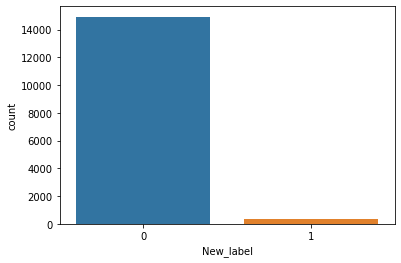

In [ ]:
sns.countplot(y)

# 3. Models

## 3.1 Auto-Encoders

In [ ]:
def auto_encoder(dims, init):
    stack_layers = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(stack_layers-1):
        x = Dense(dims[i + 1], activation='relu',  kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (stack_layers - 1))(x)
    x = encoded

    # internal layers of decoder
    for i in range(stack_layers-1, 0, -1):
        x = Dense(dims[i], activation='relu', kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

### Configurations

In [ ]:
#No of Clusters
n_clusters = 2
#dimensions
dims = [X.shape[-1], 500, 500, 2000, 20] #embedded dim -> 10,20, 50, 100
#Pre_trained Optimizer
Pre_train_optimizer = SGD(learning_rate=0.1, momentum=0.9)
#initialization
init = tf.keras.initializers.RandomNormal(mean=0,stddev=0.01)

In [ ]:
autoencoder, encoder = auto_encoder(dims, init=init)

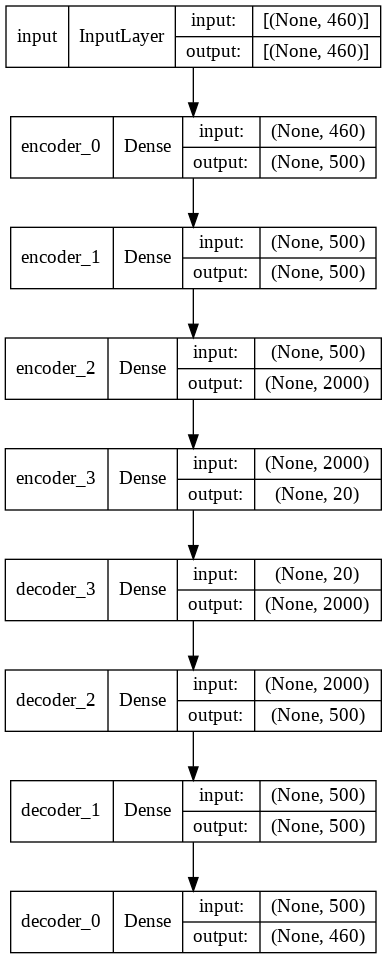

In [ ]:
plot_model(autoencoder,show_shapes=True)

## Pre-Training (Training Auto-Encoder)

In [ ]:
path = '/content/drive/My Drive/HPC Dataset/results'

In [ ]:
autoencoder.compile(optimizer=Pre_train_optimizer, loss='mse')
#call_back = keras.callbacks.EarlyStopping(monitor='loss',patience=5) 
autoencoder.fit(X, X, batch_size=128, epochs=100,verbose=1)
autoencoder.save_weights(path + '/ae_weights_20d.h5')

Epoch 1/100
120/120 [==============================] - 2s 9ms/step - loss: 0.1205
Epoch 2/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0368
Epoch 3/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 4/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 6/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 7/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 8/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 9/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 10/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 11/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 12/100
120/120 [==============================] - 1s 9ms/step - loss: 0.0303
Epoch 13/100


## 3.2 DEC Soft Labeling 

In [ ]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        
        return q
        
    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

# 3.3 DEC Model

In [ ]:
index = 0
maxiter = 1000 
batch_size = 128
update_interval = 140 
index_array = np.arange(X.shape[0])
# tolerance threshold to stop training
tol = 0.01 

In [ ]:
#No of Clusters
n_clusters = 2
#Pre_trained Optimizer
Pre_train_optimizer = SGD(learning_rate=0.01, momentum=0.9)
#initialization
init = tf.keras.initializers.RandomNormal(mean=0,stddev=0.01)

In [ ]:
def auto_encoder(dims, init):
    stack_layers = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(stack_layers-1):
        x = Dense(dims[i + 1], activation='relu',  kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (stack_layers - 1))(x)
    x = encoded

    # internal layers of decoder
    for i in range(stack_layers-1, 0, -1):
        x = Dense(dims[i], activation='relu', kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [ ]:
autoencoder, encoder = auto_encoder(dims, init=init)
autoencoder.load_weights(path + '/ae_weights_20d.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

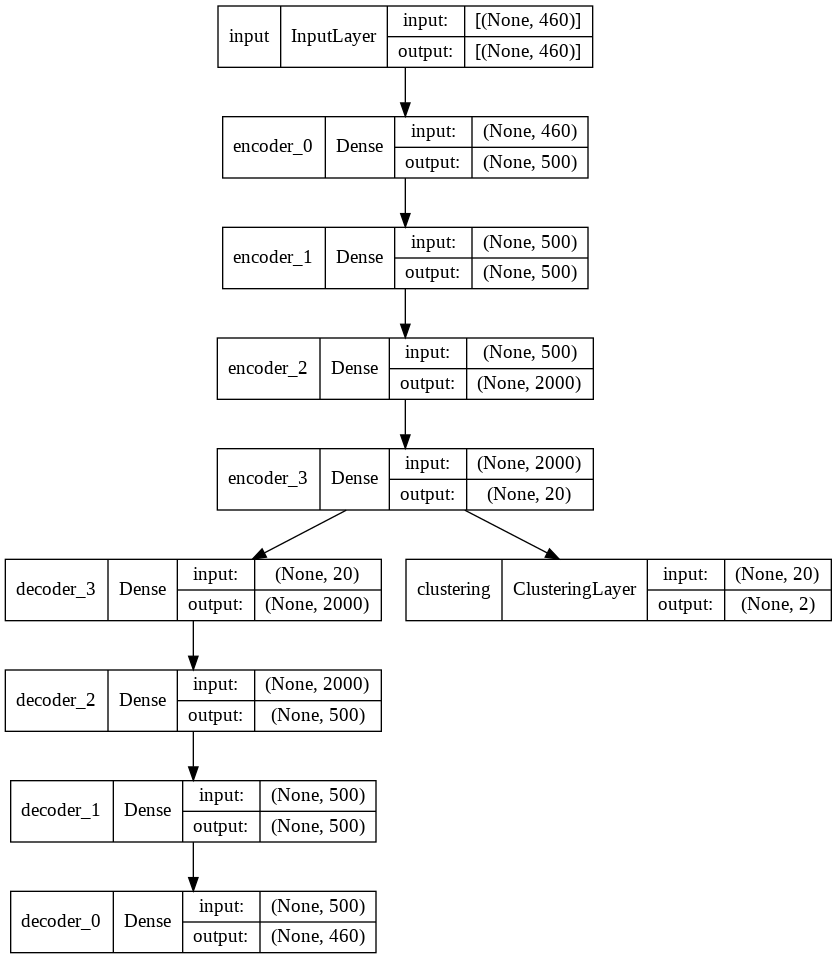

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(X))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.5, 1], optimizer=Pre_train_optimizer)

## Iterative Training 

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(X, verbose=0)
        # update the auxiliary target distribution p
        p = target_distribution(q)  

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
    loss = model.train_on_batch(x=X.iloc[idx], y=[p[idx], X.iloc[idx]])
    index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0

#model.save_weights(path + '/b_DEC_model_final.h5')

delta_label  0.008425865447419988 < tol  0.01
Reached tolerance threshold. Stopping training.


In [ ]:
# evaluation of model prediction 
q, _ = model.predict(X, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred_final = q.argmax(1)

## Visualizing Clusters in Embedded Space

In [ ]:
x_embedded = TSNE(n_components=2).fit_transform(X)
x_embedded.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(15310, 2)

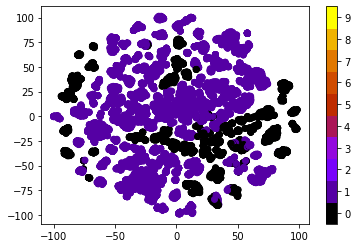

In [ ]:
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred_final, cmap=plt.cm.get_cmap("gnuplot", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

# 4. Evaluation

## 4.1 Clustering Accuracy

In [ ]:
y_true = y.values
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred_final.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
acc

0.6986936642717179

## 4.2 Silhouette Score

In [ ]:
score = silhouette_score(X, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, Deep clustering silhouette score is 0.40432901565570867)


## 4.3 Normalized Mutual Information

In [ ]:
print(normalized_mutual_info_score(y,y_pred))

0.003249673763462137
